In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import zipfile
import os


In [2]:
zip_path = '/content/drive/MyDrive/archive (1).zip'
extract_path = '/content/autoencoder_face_mask_dataset'  # Define the path where you want to extract the dataset

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check the extraction
print("Files extracted to:", extract_path)
print("Contents:", os.listdir(extract_path))

Files extracted to: /content/autoencoder_face_mask_dataset
Contents: ['Face Mask Dataset']


In [3]:
img_height, img_width = 128, 128
batch_size = 32

# Define the path to your extracted dataset
dataset_path = '/content/autoencoder_face_mask_dataset'  # Path to the extracted dataset directory

# Create an instance of ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')  # 20% for validation

# Training data generator with augmentation
train_generator = datagen.flow_from_directory(
    dataset_path,               # Path to the dataset directory
    target_size=(img_height, img_width),  # Resize images
    batch_size=batch_size,
    class_mode='input',         # 'input' mode for autoencoders
    subset='training',          # Use subset='training' for training data
    shuffle=True                # Shuffle data
)
# Validation data generator without augmentation
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    dataset_path,               # Path to the dataset directory
    target_size=(img_height, img_width),  # Resize images
    batch_size=batch_size,
    class_mode='input',         # 'input' mode for autoencoders
    subset='validation',        # Use subset='validation' for validation data
    shuffle=True                # Shuffle data
)

Found 9434 images belonging to 1 classes.
Found 2358 images belonging to 1 classes.


In [8]:
from tensorflow.keras.layers import BatchNormalization, LeakyReLU

# Encoder
input_img = Input(shape=(img_height, img_width, 3))
x = Conv2D(32, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496 

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint('best_autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with callbacks
history = autoencoder.fit(
    train_generator,
    epochs=2,
    batch_size=batch_size,
    shuffle=True,
    validation_data=validation_generator,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)


Epoch 1/2
295/295 [==============================] - 1213s 4s/step - loss: 0.5342 - val_loss: 0.5607 - lr: 0.0010
Epoch 2/2


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


295/295 [==============================] - 1193s 4s/step - loss: 0.5284 - val_loss: 0.5223 - lr: 0.0010


In [17]:
# Test data generator without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator - remove the subset argument since you don't have a dedicated test set
test_generator = test_datagen.flow_from_directory(
    '/content/autoencoder_face_mask_dataset',               # Path to the dataset directory
    target_size=(img_height, img_width),  # Resize images
    batch_size=batch_size,
    class_mode='input',         # 'input' mode for autoencoders
    shuffle=False                # No need to shuffle test data
)

loss = autoencoder.evaluate(test_generator) # Evaluate on test data, expect only loss
print(f'Test loss: {loss}')
# Removed accuracy calculation and print as it's not applicable for autoencoders

Found 11792 images belonging to 1 classes.
369/369 [==============================] - 362s 980ms/step - loss: 0.5306
Test loss: 0.530617356300354


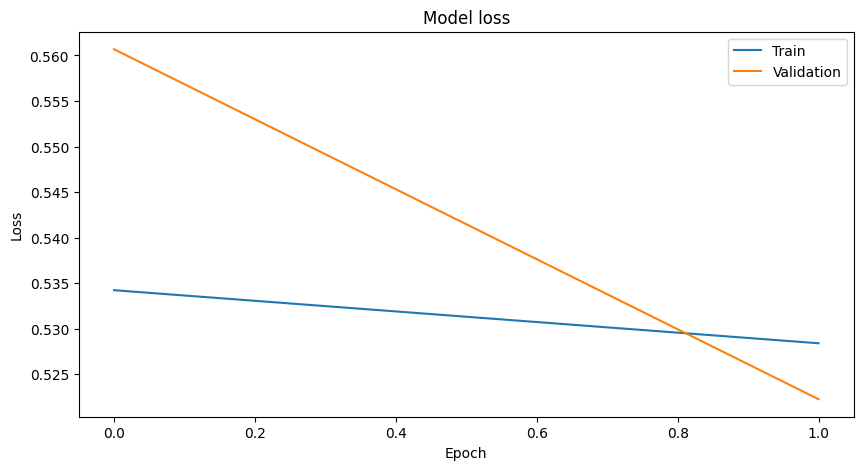

In [18]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1/1 [==============================] - 1s 965ms/step


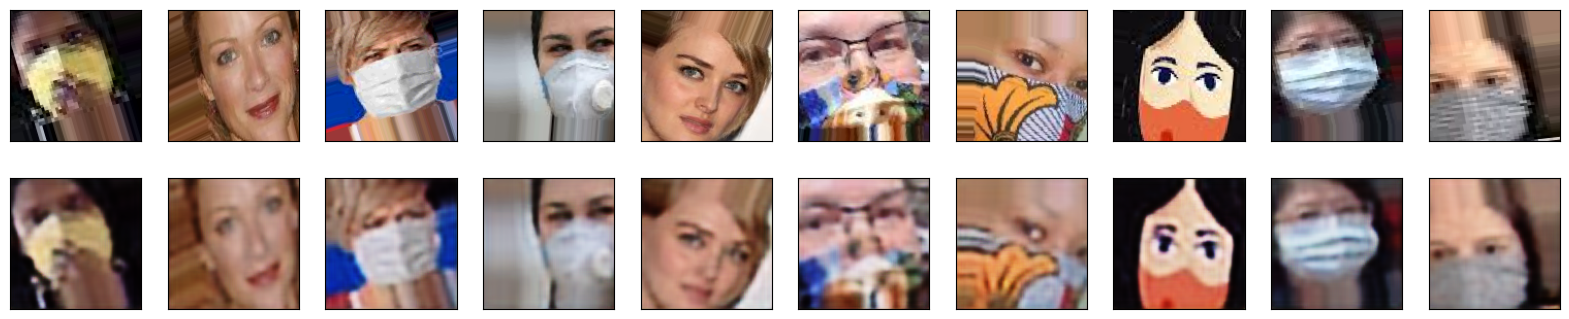

In [19]:
# Get a batch of validation data
x_val, _ = next(validation_generator)

# Predict reconstructed images
decoded_imgs = autoencoder.predict(x_val)

# Display original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
# Compile the model with a different loss function
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
